## Imports and dataset

In [1]:
from src.models.optimized_bnn import BayesianNN, DBNN
from src.utils2 import plot_ppds

from src.attacks.distr_attacks_bnn_jax import fgsm_attack, mlmc_attack, kl_to_appd

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

# Wine dataset

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [7]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/3bnn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    model.save('../src/models/3bnn')

#### appd = N(2mu, 2var)

In [8]:
# Attack example
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.Normal(2 * mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.001, n_iter=1000)

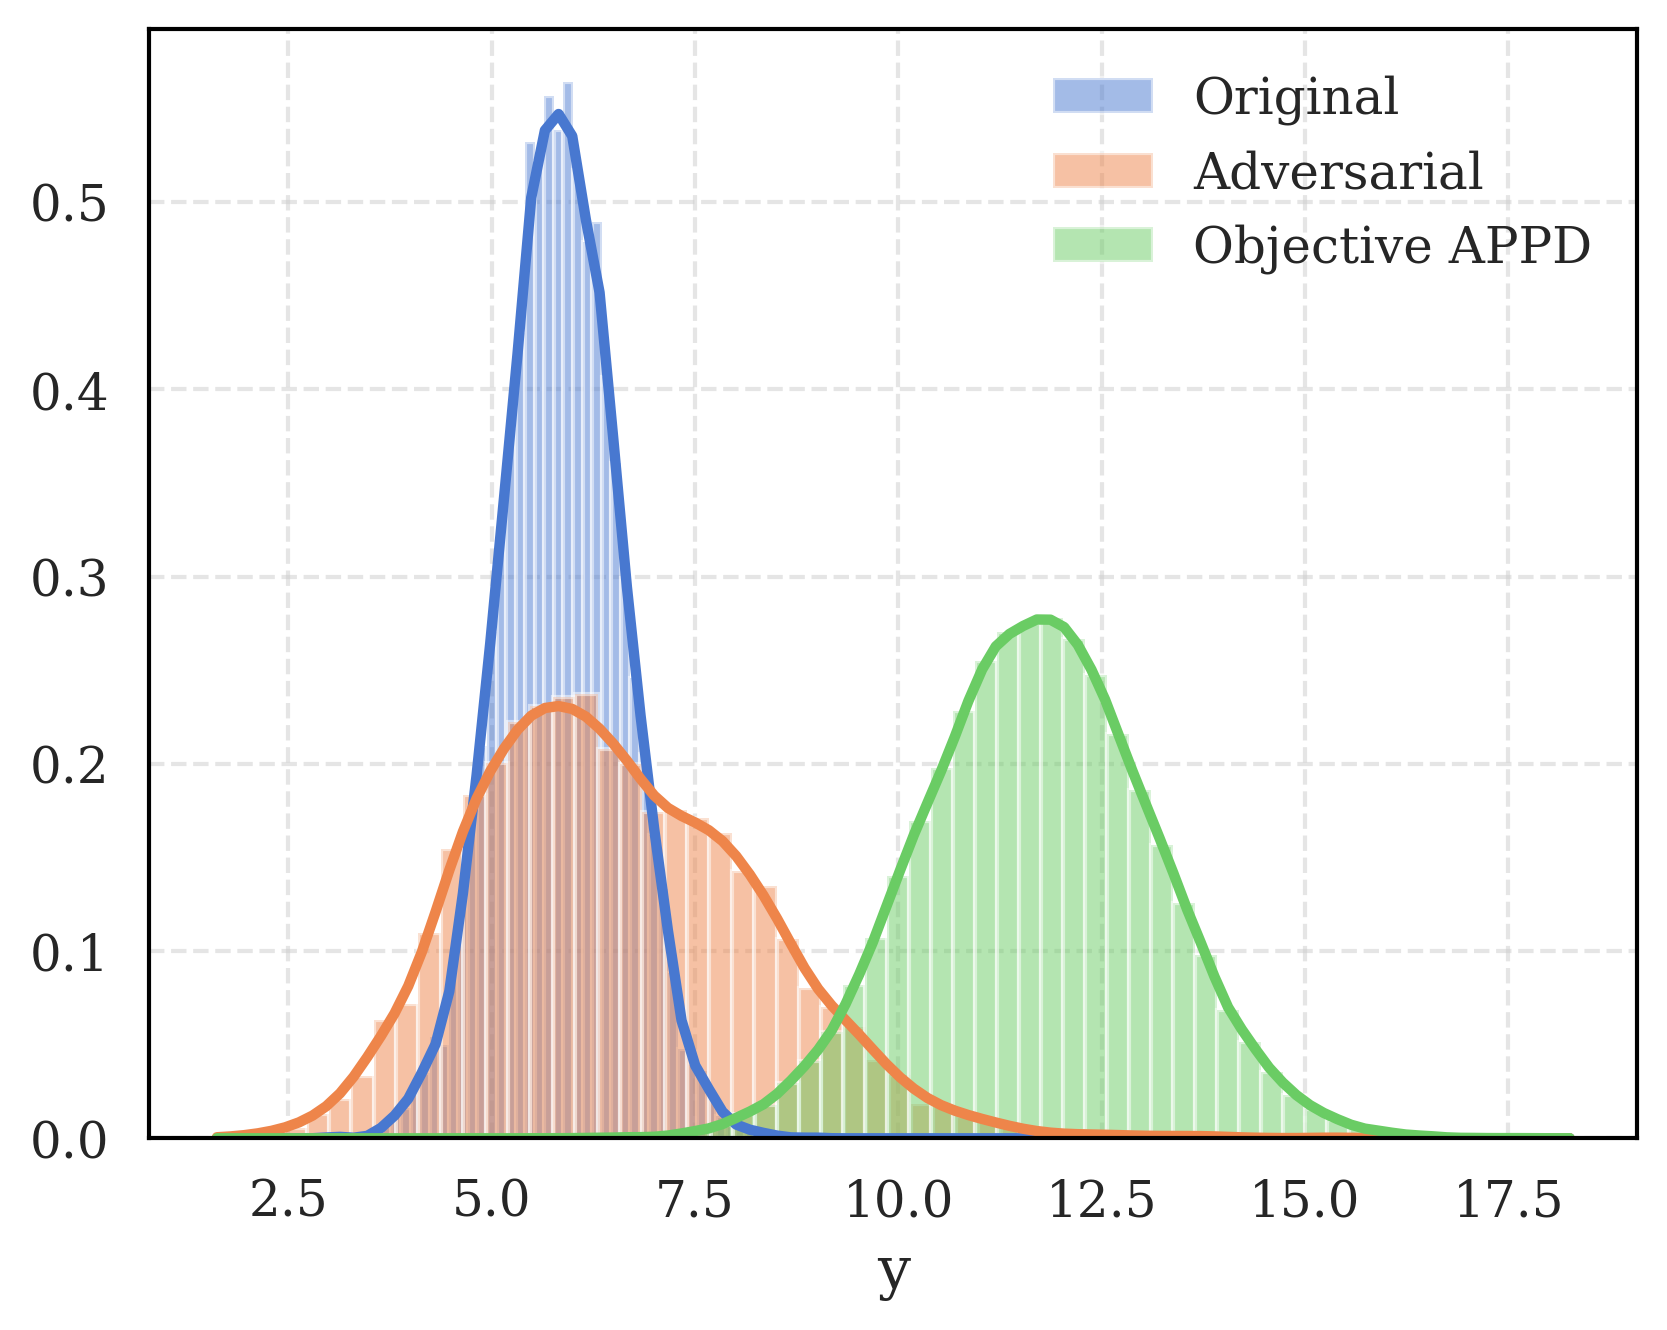

In [9]:
plot_ppds(model, x, x_adv_distr, jax.random.PRNGKey(42), appd)

In [10]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.Normal(2 * mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=1000, verbose=False)
    mu_adv = model.sample_predictive_distribution(x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(x_adv_distr, 1000).var()
    kl = kl_to_appd(mu_adv, sigma2_adv, 2 * mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    mu_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).mean()
    sigma2_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).var()
    kl_fgsm = kl_to_appd(mu_fgsm, sigma2_fgsm, 2 * mu, 4 * std ** 2).item()
    return kl, kl_fgsm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 10)
kl_alls = []

for _ in range(3):
    print(_)
    # Use joblib to parallelize the computation of KL divergences
    #kl_values = Parallel(n_jobs=n_jobs)(delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons)
    kl_values = []
    for epsilon in epsilons:
        kl_values.append(compute_kl_divergence(epsilon))
    kl_alls.append(kl_values)

kl_mlmc_1000 = np.array(kl_alls)[:, :, 0]
kl_fsgm_1000 = np.array(kl_alls)[:, :, 1]


0


KeyboardInterrupt: 

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_18135/3803497156.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_18135/3803497156.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


ValueError: Axis limits cannot be NaN or Inf

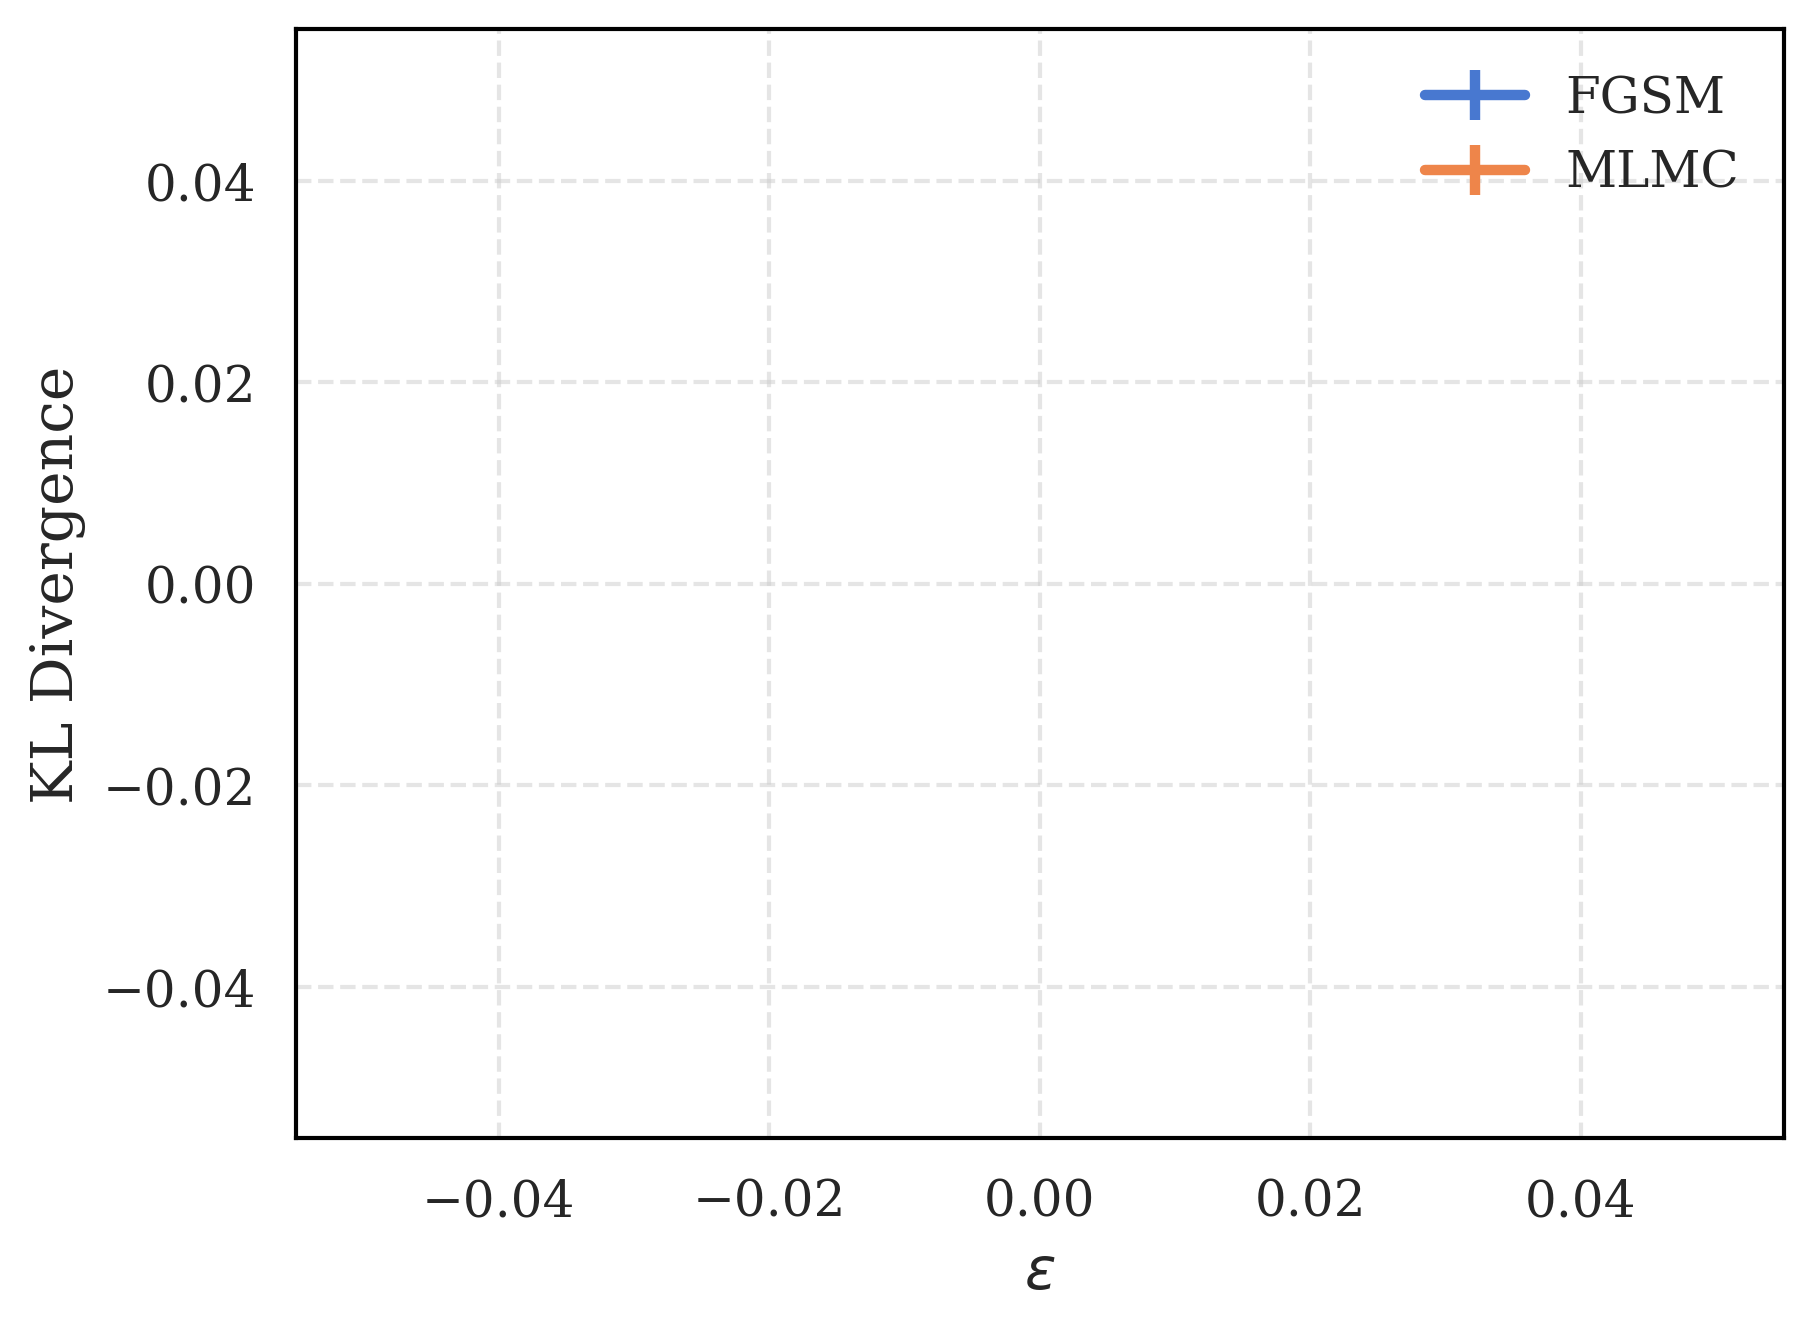

In [ ]:
# error bars as std
plt.errorbar(epsilons, np.mean(kl_fsgm_1000, axis=0), yerr=2*np.std(kl_fsgm_1000, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc_1000, axis=0), yerr=2*np.std(kl_mlmc_1000, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc_1000) + 0.1)

In [ ]:
#plt.errorbar(epsilons, np.mean(kl_fsgm_1000, axis=0), yerr=2*np.std(kl_fsgm_1000, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc_1000, axis=0), yerr=2*np.std(kl_mlmc_1000, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc_1000) + 0.1)

#### appd = N(mu, 2var)

In [ ]:
# Attack example
x = X_test[17,:].copy()
x = jnp.array(x)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.normal.Normal(mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.001, n_iter=1000)
plot_ppds(model, x, x_adv_distr, appd)

#### appd = N(3 + mu, 2var)

In [ ]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66
x = X_test[17,:].copy()
x = jnp.array(x)
sigma2 = model.sample_posterior_distribution(1000)['sigma2'].mean()
mu = model.sample_predictive_distribution(x, 1000).mean()
std = model.sample_predictive_distribution(x, 1000).std()
appd = numpyro.distributions.normal.Normal(3 + mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=2*epsilon, R=10, lr=0.001, n_iter=1000)
    mu_adv = model.sample_predictive_distribution(x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(x_adv_distr, 1000).var()
    kl = kl_to_appd(mu_adv, sigma2_adv, 3 + mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    mu_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).mean()
    sigma2_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).var()
    kl_fsgm = kl_to_appd(mu_fgsm, sigma2_fgsm, 3 + mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)